In [1]:
import pandas as pd # Importing pandas library for data analysis
import numpy as np  # Importing numpy library for numerical computing
import seaborn as sns # Importing seaborn library for data visualization
import matplotlib
import matplotlib.pyplot as plt # Importing matplotlib library for data visualization

sns.set_context('notebook') # Setting the seaborn context for notebook style plots
sns.set_style('whitegrid') # Setting the seaborn style to whitegrid
sns.set_palette('Spectral') # Setting the seaborn color palette to Spectral

import warnings # Importing the warnings library to ignore any warning messages during analysis
warnings.filterwarnings('ignore')

# Finance related operations
from pandas_datareader import data

# Import this to silence a warning when converting data column of a dataframe on the fly
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [2]:
import statsmodels.api as sm

from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
data5 = pd.concat([pd.read_csv("2014_Financial_Data.csv"),
                    pd.read_csv("2015_Financial_Data.csv"),
                    pd.read_csv("2016_Financial_Data.csv"),
                    pd.read_csv("2017_Financial_Data.csv"),
                    pd.read_csv("2018_Financial_Data.csv"),],sort=False).drop_duplicates().sample(frac=1)
data5 = data5.rename(columns={'Unnamed: 0': 'Ticker'})
print(data5.shape)
data5.head()

(22077, 229)


,Ticker,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2015 PRICE VAR [%],Class,2016 PRICE VAR [%],2017 PRICE VAR [%],2018 PRICE VAR [%],2019 PRICE VAR [%]
4218,CTSH,1.348700e+10,0.0863,8.108000e+09,5.379000e+09,0.0,2.731000e+09,3.090000e+09,2.289000e+09,19000000.0,...,-0.3157,0.0000,0.0885,Technology,NaN,1,NaN,26.468165,NaN,NaN
3894,CLRO,2.815600e+07,-0.3265,1.478500e+07,1.337100e+07,7840000.0,1.585800e+07,2.369800e+07,-1.032700e+07,0.0,...,0.0000,-0.1608,-0.1266,Technology,NaN,1,NaN,NaN,NaN,22.962958
1443,ANY,9.030000e+06,-0.2833,7.351000e+06,1.679000e+06,3425000.0,1.087400e+07,1.429900e+07,-1.262000e+07,76000.0,...,0.0000,-0.4162,-0.1671,Technology,NaN,0,NaN,NaN,NaN,-74.740259
277,EXP,1.143492e+09,0.0723,9.118750e+08,2.316170e+08,0.0,3.719300e+07,3.719300e+07,1.944240e+08,16583000.0,...,-0.0098,0.0000,0.2095,Basic Materials,NaN,1,NaN,13.635734,NaN,NaN
1208,VFC,1.102615e+10,0.0027,5.589923e+09,5.436224e+09,0.0,3.901122e+09,3.747799e+09,1.455458e+09,88751000.0,...,-0.0077,0.0000,0.0409,Consumer Cyclical,NaN,1,NaN,43.908317,NaN,NaN


In [4]:
data5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22077 entries, 4218 to 4706
Columns: 229 entries, Ticker to 2019 PRICE VAR [%]
dtypes: float64(226), int64(1), object(2)
memory usage: 38.7+ MB


In [5]:
# Tetapkan kolom 'Ticker' sebagai indeks DataFrame
# data5 = data5.set_index('Unnamed: 0')

# Ubah kolom 'Sector' menjadi variabel kategori dengan menggantinya dengan kode numerik yang sesuai
# data5['Sector'] = data5['Sector'].astype('category').cat.codes

# Gantikan nilai NaN dengan 0
data5.fillna(0, inplace=True)



In [6]:
# Assuming data5 is the concatenated DataFrame
data_filled = data5.replace(0, np.nan)  # Replace 0 with NaN temporarily

# Calculate the percentage of non-zero values for each company
data_filled['non_zero_percentage'] = data_filled.apply(lambda x: x.count() / len(x) * 100, axis=1)

# Calculate the quartiles for non_zero_percentage
q1 = data_filled['non_zero_percentage'].quantile(0.25)
q2 = data_filled['non_zero_percentage'].quantile(0.5)
q3 = data_filled['non_zero_percentage'].quantile(0.75)

print("Q1:", q1)
print("Q2 (Median):", q2)
print("Q3:", q3)

# Set the threshold for retaining or removing companies
threshold = q1  # Example: You may choose Q1 as the threshold

# Filter the dataset based on the threshold
data_cleaned = data_filled[data_filled['non_zero_percentage'] >= threshold]

# Replace NaN back to 0
data_cleaned = data_cleaned.fillna(0)

Q1: 68.5589519650655
Q2 (Median): 77.72925764192141
Q3: 84.71615720524017


In [7]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16608 entries, 4218 to 4706
Columns: 230 entries, Ticker to non_zero_percentage
dtypes: float64(228), object(2)
memory usage: 29.3+ MB


In [8]:
average_indicators_filled = 229 * 0.7772925764192141
print(average_indicators_filled)


178.00000000000003


In [9]:
data_cleaned.head()

,Ticker,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,R&D Expense Growth,SG&A Expenses Growth,Sector,2015 PRICE VAR [%],Class,2016 PRICE VAR [%],2017 PRICE VAR [%],2018 PRICE VAR [%],2019 PRICE VAR [%],non_zero_percentage
4218,CTSH,1.348700e+10,0.0863,8.108000e+09,5.379000e+09,0.0,2.731000e+09,3.090000e+09,2.289000e+09,19000000.0,...,0.0000,0.0885,Technology,0.0,1.0,0.0,26.468165,0.0,0.000000,86.462882
3894,CLRO,2.815600e+07,-0.3265,1.478500e+07,1.337100e+07,7840000.0,1.585800e+07,2.369800e+07,-1.032700e+07,0.0,...,-0.1608,-0.1266,Technology,0.0,1.0,0.0,0.000000,0.0,22.962958,74.672489
1443,ANY,9.030000e+06,-0.2833,7.351000e+06,1.679000e+06,3425000.0,1.087400e+07,1.429900e+07,-1.262000e+07,76000.0,...,-0.4162,-0.1671,Technology,0.0,0.0,0.0,0.000000,0.0,-74.740259,72.925764
277,EXP,1.143492e+09,0.0723,9.118750e+08,2.316170e+08,0.0,3.719300e+07,3.719300e+07,1.944240e+08,16583000.0,...,0.0000,0.2095,Basic Materials,0.0,1.0,0.0,13.635734,0.0,0.000000,91.266376
1208,VFC,1.102615e+10,0.0027,5.589923e+09,5.436224e+09,0.0,3.901122e+09,3.747799e+09,1.455458e+09,88751000.0,...,0.0000,0.0409,Consumer Cyclical,0.0,1.0,0.0,43.908317,0.0,0.000000,91.266376


In [10]:
data_cleaned.drop('Class', axis=1, inplace=True)
data_cleaned

,Ticker,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2015 PRICE VAR [%],2016 PRICE VAR [%],2017 PRICE VAR [%],2018 PRICE VAR [%],2019 PRICE VAR [%],non_zero_percentage
4218,CTSH,1.348700e+10,0.0863,8.108000e+09,5.379000e+09,0.0,2.731000e+09,3.090000e+09,2.289000e+09,19000000.0,...,-0.3157,0.0000,0.0885,Technology,0.000000,0.0,26.468165,0.000000,0.000000,86.462882
3894,CLRO,2.815600e+07,-0.3265,1.478500e+07,1.337100e+07,7840000.0,1.585800e+07,2.369800e+07,-1.032700e+07,0.0,...,0.0000,-0.1608,-0.1266,Technology,0.000000,0.0,0.000000,0.000000,22.962958,74.672489
1443,ANY,9.030000e+06,-0.2833,7.351000e+06,1.679000e+06,3425000.0,1.087400e+07,1.429900e+07,-1.262000e+07,76000.0,...,0.0000,-0.4162,-0.1671,Technology,0.000000,0.0,0.000000,0.000000,-74.740259,72.925764
277,EXP,1.143492e+09,0.0723,9.118750e+08,2.316170e+08,0.0,3.719300e+07,3.719300e+07,1.944240e+08,16583000.0,...,-0.0098,0.0000,0.2095,Basic Materials,0.000000,0.0,13.635734,0.000000,0.000000,91.266376
1208,VFC,1.102615e+10,0.0027,5.589923e+09,5.436224e+09,0.0,3.901122e+09,3.747799e+09,1.455458e+09,88751000.0,...,-0.0077,0.0000,0.0409,Consumer Cyclical,0.000000,0.0,43.908317,0.000000,0.000000,91.266376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2898,IMKTA,4.092805e+09,0.0225,3.112636e+09,9.801694e+08,0.0,8.560741e+08,8.553457e+08,1.248236e+08,47569703.0,...,-0.0140,0.0000,0.0226,Consumer Defensive,0.000000,0.0,0.000000,0.000000,74.672590,86.026201
3155,PEG,1.088600e+10,0.0921,7.036000e+09,3.850000e+09,0.0,0.000000e+00,1.227000e+09,2.623000e+09,389000000.0,...,0.0454,0.0000,0.0000,Utilities,-3.975530,0.0,0.000000,0.000000,0.000000,88.646288
365,MBII,9.136000e+06,0.0817,9.438000e+06,-3.020000e+05,19281000.0,2.895000e+07,4.823100e+07,-4.853300e+07,2907000.0,...,0.6248,0.0769,0.9278,Basic Materials,-71.128608,0.0,0.000000,0.000000,0.000000,73.799127
972,IBIO,9.480000e+05,-0.4878,0.000000e+00,9.480000e+05,3156000.0,7.685000e+06,1.084100e+07,-9.893000e+06,807000.0,...,0.0000,-0.0970,0.5303,Healthcare,0.000000,0.0,-51.351353,0.000000,0.000000,74.672489


In [11]:
data_cleaned.sort_values('Ticker', ascending=True)


,Ticker,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2015 PRICE VAR [%],2016 PRICE VAR [%],2017 PRICE VAR [%],2018 PRICE VAR [%],2019 PRICE VAR [%],non_zero_percentage
557,A,4.914000e+09,0.0988,2.227000e+09,2.687000e+09,385000000.0,1.374000e+09,1.759000e+09,928000000.0,75000000.0,...,-0.1054,0.1357,0.1180,Healthcare,0.000000,0.000000,0.000000,0.000000,30.976102,93.013100
492,A,4.038000e+09,-0.0025,1.997000e+09,2.041000e+09,330000000.0,1.189000e+09,1.519000e+09,522000000.0,66000000.0,...,-0.0048,-0.0782,-0.0083,Healthcare,0.000000,13.194947,0.000000,0.000000,0.000000,92.139738
460,A,4.048000e+09,0.0395,2.072000e+09,1.976000e+09,358000000.0,1.199000e+09,1.557000e+09,419000000.0,110000000.0,...,-0.3838,0.0623,0.0127,Healthcare,4.179246,0.000000,0.000000,0.000000,0.000000,92.139738
536,A,4.472000e+09,0.0643,2.063000e+09,2.409000e+09,339000000.0,1.229000e+09,1.568000e+09,841000000.0,79000000.0,...,0.0562,0.0304,-0.0192,Healthcare,0.000000,0.000000,0.000000,0.717881,0.000000,93.449782
524,A,4.202000e+09,0.0406,2.005000e+09,2.197000e+09,329000000.0,1.253000e+09,1.582000e+09,615000000.0,72000000.0,...,0.1505,-0.0030,0.0538,Healthcare,0.000000,0.000000,45.350940,0.000000,0.000000,92.139738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443,ZUMZ,8.362680e+08,0.0399,5.612660e+08,2.750020e+08,0.0,2.352590e+08,2.352590e+08,39743000.0,0.0,...,0.0000,0.0000,0.0575,Consumer Cyclical,0.000000,0.000000,0.000000,-4.150000,0.000000,79.912664
1397,ZUMZ,8.041830e+08,-0.0091,5.355590e+08,2.686240e+08,0.0,2.224590e+08,2.224590e+08,46165000.0,0.0,...,0.0000,0.0000,0.0322,Consumer Cyclical,0.000000,0.000000,-5.318182,0.000000,0.000000,80.349345
1198,ZYME,5.176200e+07,3.7018,0.000000e+00,5.176200e+07,41749000.0,1.855000e+07,6.076000e+07,-8998000.0,422000.0,...,-1.0000,0.1340,0.4776,Healthcare,0.000000,0.000000,0.000000,85.049794,0.000000,69.432314
1156,ZYME,1.100900e+07,0.1396,0.000000e+00,1.100900e+07,36816000.0,1.255400e+07,4.887300e+07,-37864000.0,950000.0,...,0.0000,0.4933,1.4064,Healthcare,0.000000,0.000000,-41.592308,0.000000,0.000000,68.558952


In [12]:
# Define a function to set the class value based on the stock price gain
def set_class(value):
    if value >= 0:
        return 1
    else:
        return 0

# Iterate through the years and create new class columns
for year in range(2015, 2020):
    price_var_col = f'{year} PRICE VAR [%]'
    class_col = f'Class{year % 2000}'

    # Apply the set_class function to each value in the price_var_col
    data_cleaned[class_col] = data_cleaned[price_var_col].apply(set_class)

# Rearrange columns to put the class columns next to the corresponding price var columns
new_column_order = []
for year in range(2015, 2020):
    new_column_order.append(f'{year} PRICE VAR [%]')
    new_column_order.append(f'Class{year % 2000}')

remaining_columns = [col for col in data_cleaned.columns if col not in new_column_order]
new_column_order.extend(remaining_columns)

data_cleaned = data_cleaned[new_column_order]


In [13]:
data_cleaned.head(20)

,2015 PRICE VAR [%],Class15,2016 PRICE VAR [%],Class16,2017 PRICE VAR [%],Class17,2018 PRICE VAR [%],Class18,2019 PRICE VAR [%],Class19,...,3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,non_zero_percentage
4218,0.000000,1,0.000000,1,26.468165,1,0.000000,1,0.000000,1,...,0.0000,0.1079,0.0000,0.0920,0.1601,-0.3157,0.0000,0.0885,Technology,86.462882
3894,0.000000,1,0.000000,1,0.000000,1,0.000000,1,22.962958,1,...,-0.2328,-0.1298,-0.1012,-0.1320,-0.1151,0.0000,-0.1608,-0.1266,Technology,74.672489
1443,0.000000,1,0.000000,1,0.000000,1,0.000000,1,-74.740259,0,...,0.0000,-0.4024,-0.1511,-0.8645,-1.2010,0.0000,-0.4162,-0.1671,Technology,72.925764
277,0.000000,1,0.000000,1,13.635734,1,0.000000,1,0.000000,1,...,0.0000,0.0585,0.0345,0.0018,0.0324,-0.0098,0.0000,0.2095,Basic Materials,91.266376
1208,0.000000,1,0.000000,1,43.908317,1,0.000000,1,0.000000,1,...,0.1930,-0.1094,-0.0841,0.0103,-0.0554,-0.0077,0.0000,0.0409,Consumer Cyclical,91.266376
3299,2.073556,1,0.000000,1,0.000000,1,0.000000,1,0.000000,1,...,0.2164,-0.0605,0.0347,0.0470,0.0542,-0.0030,0.1058,-0.0075,Technology,92.576419
1788,0.000000,1,0.000000,1,0.000000,1,0.000000,1,6.141730,1,...,0.0000,0.1650,0.0000,0.0342,0.0093,2.7910,-0.0022,0.0112,Consumer Cyclical,72.489083
1975,0.000000,1,0.000000,1,41.485143,1,0.000000,1,0.000000,1,...,0.0000,0.0000,0.0000,1.8270,19.6387,0.0000,0.0000,0.1055,Industrials,73.799127
1346,0.000000,1,0.000000,1,-54.571552,0,0.000000,1,0.000000,1,...,0.0000,1.0245,0.0000,0.6984,0.2945,1.2020,0.0000,1.2386,Consumer Cyclical,82.969432
1896,0.000000,1,134.146341,1,0.000000,1,0.000000,1,0.000000,1,...,0.0000,-0.0124,-0.0329,-0.0233,-0.9893,247.3421,0.0000,-0.0125,Industrials,80.349345


In [14]:
# Get the current column order
current_column_order = data_cleaned.columns.tolist()

# Create a list of the 'PRICE VAR [%]' and 'Class' columns to move
columns_to_move = []
for year in range(2015, 2020):
    columns_to_move.append(f'{year} PRICE VAR [%]')
    columns_to_move.append(f'Class{year % 2000}')

# Remove the 'PRICE VAR [%]' and 'Class' columns from the current column order
remaining_columns = [col for col in current_column_order if col not in columns_to_move]

# Create a new column order with the 'PRICE VAR [%]' and 'Class' columns at the rightmost side
new_column_order = remaining_columns + columns_to_move

# Reorder the DataFrame columns based on the new column order
data_cleaned = data_cleaned[new_column_order]

In [15]:
data_cleaned.head()

,Ticker,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,2015 PRICE VAR [%],Class15,2016 PRICE VAR [%],Class16,2017 PRICE VAR [%],Class17,2018 PRICE VAR [%],Class18,2019 PRICE VAR [%],Class19
4218,CTSH,1.348700e+10,0.0863,8.108000e+09,5.379000e+09,0.0,2.731000e+09,3.090000e+09,2.289000e+09,19000000.0,...,0.0,1,0.0,1,26.468165,1,0.0,1,0.000000,1
3894,CLRO,2.815600e+07,-0.3265,1.478500e+07,1.337100e+07,7840000.0,1.585800e+07,2.369800e+07,-1.032700e+07,0.0,...,0.0,1,0.0,1,0.000000,1,0.0,1,22.962958,1
1443,ANY,9.030000e+06,-0.2833,7.351000e+06,1.679000e+06,3425000.0,1.087400e+07,1.429900e+07,-1.262000e+07,76000.0,...,0.0,1,0.0,1,0.000000,1,0.0,1,-74.740259,0
277,EXP,1.143492e+09,0.0723,9.118750e+08,2.316170e+08,0.0,3.719300e+07,3.719300e+07,1.944240e+08,16583000.0,...,0.0,1,0.0,1,13.635734,1,0.0,1,0.000000,1
1208,VFC,1.102615e+10,0.0027,5.589923e+09,5.436224e+09,0.0,3.901122e+09,3.747799e+09,1.455458e+09,88751000.0,...,0.0,1,0.0,1,43.908317,1,0.0,1,0.000000,1


In [16]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16608 entries, 4218 to 4706
Columns: 234 entries, Ticker to Class19
dtypes: float64(227), int64(5), object(2)
memory usage: 29.8+ MB


In [17]:
data_selected = data_cleaned

# Replace 0 values with NaN
data_selected.replace(0, np.nan, inplace=True)

# Group by Ticker and Sector, then calculate the mean of non-NaN values for each year
average_data = data_selected.groupby(['Ticker', 'Sector']).mean()

# Reset the index to make 'Ticker' and 'Sector' columns again
average_data.reset_index(inplace=True)


In [18]:
average_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3769 entries, 0 to 3768
Columns: 234 entries, Ticker to Class19
dtypes: float64(232), object(2)
memory usage: 6.7+ MB


In [19]:
average_data.head()

,Ticker,Sector,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,2015 PRICE VAR [%],Class15,2016 PRICE VAR [%],Class16,2017 PRICE VAR [%],Class17,2018 PRICE VAR [%],Class18,2019 PRICE VAR [%],Class19
0,A,Healthcare,4.334800e+09,0.04814,2.072800e+09,2.262000e+09,348200000.0,1.248800e+09,1.597000e+09,6.650000e+08,...,4.179246,1.0,13.194947,1.0,45.350940,1.0,0.717881,1.0,30.976102,1.0
1,AA,Basic Materials,1.139300e+10,0.02115,8.997000e+09,2.396000e+09,41250000.0,3.092500e+08,1.647000e+09,7.490000e+08,...,NaN,1.0,22.046441,1.0,86.853968,1.0,-51.821641,1.0,-18.025913,1.0
2,AAL,Industrials,4.218900e+10,0.12840,1.863500e+10,2.355400e+10,NaN,1.209240e+10,1.907400e+10,4.480000e+09,...,-20.768098,1.0,15.404948,1.0,13.344850,1.0,-38.817936,1.0,-10.602069,1.0
3,AAME,Financial Services,1.730004e+08,0.02386,1.121842e+08,6.081620e+07,NaN,4.228860e+07,5.544040e+07,5.375800e+06,...,24.445114,1.0,-14.942088,1.0,-16.654341,1.0,-25.389821,1.0,-20.250605,1.0
4,AAN,Industrials,3.259027e+09,0.11624,2.951072e+08,2.963920e+09,NaN,1.392605e+09,2.730039e+09,2.338810e+08,...,-26.649795,1.0,41.604419,1.0,25.314724,1.0,6.825130,1.0,31.675678,1.0


In [20]:
from scipy import stats

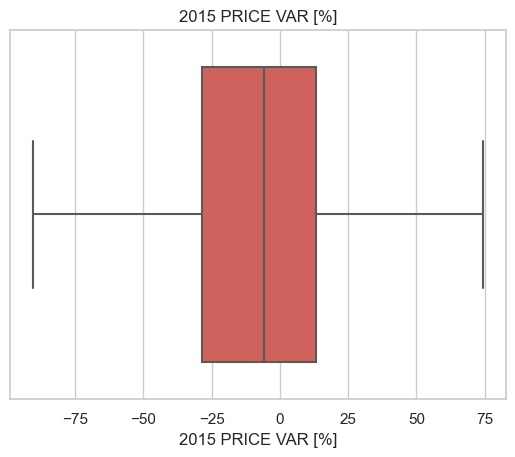

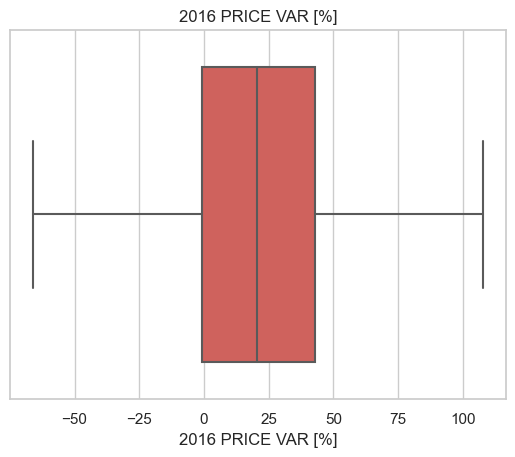

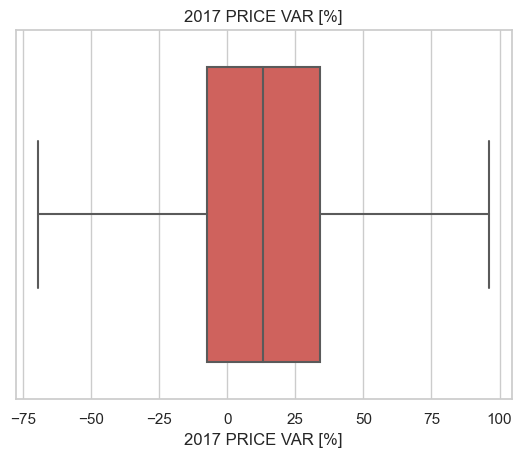

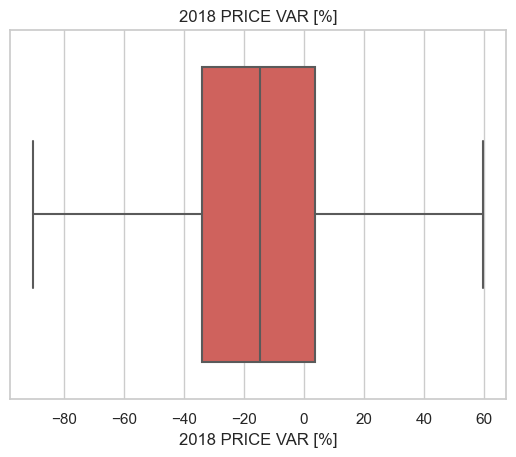

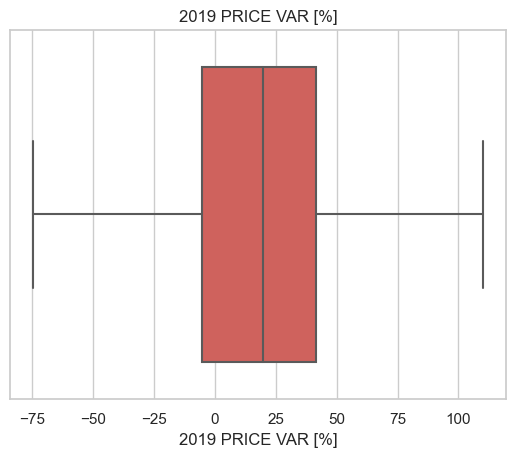

In [21]:
# Define the columns of interest
columns_of_interest = ['2015 PRICE VAR [%]', '2016 PRICE VAR [%]', '2017 PRICE VAR [%]', '2018 PRICE VAR [%]', '2019 PRICE VAR [%]']

# Create a box plot for each column with showfliers=False
for column in columns_of_interest:
    sns.boxplot(x=average_data[column], showfliers=False)
    plt.title(column)
    plt.show()

# Calculate the interquartile range (IQR) for each column and store the outlier bounds
outlier_bounds = {}
for column in columns_of_interest:
    Q1 = average_data[column].quantile(0.25)
    Q3 = average_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_bounds[column] = (lower_bound, upper_bound)

# Create a new DataFrame without the outliers
average_data_no_outliers = average_data.copy()
for column in columns_of_interest:
    lower_bound, upper_bound = outlier_bounds[column]
    average_data_no_outliers = average_data_no_outliers[(average_data_no_outliers[column] >= lower_bound) & (average_data_no_outliers[column] <= upper_bound)]


In [22]:
average_data_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2193 entries, 0 to 3767
Columns: 234 entries, Ticker to Class19
dtypes: float64(232), object(2)
memory usage: 3.9+ MB


In [23]:
average_data_no_outliers.head()

,Ticker,Sector,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,2015 PRICE VAR [%],Class15,2016 PRICE VAR [%],Class16,2017 PRICE VAR [%],Class17,2018 PRICE VAR [%],Class18,2019 PRICE VAR [%],Class19
0,A,Healthcare,4.334800e+09,0.04814,2.072800e+09,2.262000e+09,348200000.0,1.248800e+09,1.597000e+09,6.650000e+08,...,4.179246,1.0,13.194947,1.0,45.350940,1.0,0.717881,1.0,30.976102,1.0
2,AAL,Industrials,4.218900e+10,0.12840,1.863500e+10,2.355400e+10,NaN,1.209240e+10,1.907400e+10,4.480000e+09,...,-20.768098,1.0,15.404948,1.0,13.344850,1.0,-38.817936,1.0,-10.602069,1.0
3,AAME,Financial Services,1.730004e+08,0.02386,1.121842e+08,6.081620e+07,NaN,4.228860e+07,5.544040e+07,5.375800e+06,...,24.445114,1.0,-14.942088,1.0,-16.654341,1.0,-25.389821,1.0,-20.250605,1.0
4,AAN,Industrials,3.259027e+09,0.11624,2.951072e+08,2.963920e+09,NaN,1.392605e+09,2.730039e+09,2.338810e+08,...,-26.649795,1.0,41.604419,1.0,25.314724,1.0,6.825130,1.0,31.675678,1.0
5,AAOI,Technology,2.461718e+08,0.33164,1.570306e+08,8.914120e+07,30774000.0,3.480920e+07,6.558320e+07,2.355800e+07,...,59.036144,1.0,43.891953,1.0,63.722940,1.0,-59.298337,1.0,-25.188917,1.0


In [24]:
# Create a new column to store the sum of price var for each stock
average_data_no_outliers['PRICE VAR [%]'] = 0

# Iterate over the rows in the dataframe
for i, row in average_data_no_outliers.iterrows():
    # Get the price var for each year and sum them up
    price_var_sum = sum(row[['2015 PRICE VAR [%]', '2016 PRICE VAR [%]', '2017 PRICE VAR [%]', '2018 PRICE VAR [%]', '2019 PRICE VAR [%]']])
    
    # Update the 'PRICE VAR [%]' column with the total price var
    average_data_no_outliers.at[i, 'PRICE VAR [%]'] = price_var_sum


In [25]:
average_data_no_outliers.head()

,Ticker,Sector,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,Class15,2016 PRICE VAR [%],Class16,2017 PRICE VAR [%],Class17,2018 PRICE VAR [%],Class18,2019 PRICE VAR [%],Class19,PRICE VAR [%]
0,A,Healthcare,4.334800e+09,0.04814,2.072800e+09,2.262000e+09,348200000.0,1.248800e+09,1.597000e+09,6.650000e+08,...,1.0,13.194947,1.0,45.350940,1.0,0.717881,1.0,30.976102,1.0,94.419114
2,AAL,Industrials,4.218900e+10,0.12840,1.863500e+10,2.355400e+10,NaN,1.209240e+10,1.907400e+10,4.480000e+09,...,1.0,15.404948,1.0,13.344850,1.0,-38.817936,1.0,-10.602069,1.0,-41.438304
3,AAME,Financial Services,1.730004e+08,0.02386,1.121842e+08,6.081620e+07,NaN,4.228860e+07,5.544040e+07,5.375800e+06,...,1.0,-14.942088,1.0,-16.654341,1.0,-25.389821,1.0,-20.250605,1.0,-52.791741
4,AAN,Industrials,3.259027e+09,0.11624,2.951072e+08,2.963920e+09,NaN,1.392605e+09,2.730039e+09,2.338810e+08,...,1.0,41.604419,1.0,25.314724,1.0,6.825130,1.0,31.675678,1.0,78.770156
5,AAOI,Technology,2.461718e+08,0.33164,1.570306e+08,8.914120e+07,30774000.0,3.480920e+07,6.558320e+07,2.355800e+07,...,1.0,43.891953,1.0,63.722940,1.0,-59.298337,1.0,-25.188917,1.0,82.163783


In [26]:
average_data_no_outliers['Class'] = average_data_no_outliers.apply(lambda row: 1 if row['PRICE VAR [%]'] > 0 else 0, axis=1)
average_data_no_outliers.head()

,Ticker,Sector,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,2016 PRICE VAR [%],Class16,2017 PRICE VAR [%],Class17,2018 PRICE VAR [%],Class18,2019 PRICE VAR [%],Class19,PRICE VAR [%],Class
0,A,Healthcare,4.334800e+09,0.04814,2.072800e+09,2.262000e+09,348200000.0,1.248800e+09,1.597000e+09,6.650000e+08,...,13.194947,1.0,45.350940,1.0,0.717881,1.0,30.976102,1.0,94.419114,1
2,AAL,Industrials,4.218900e+10,0.12840,1.863500e+10,2.355400e+10,NaN,1.209240e+10,1.907400e+10,4.480000e+09,...,15.404948,1.0,13.344850,1.0,-38.817936,1.0,-10.602069,1.0,-41.438304,0
3,AAME,Financial Services,1.730004e+08,0.02386,1.121842e+08,6.081620e+07,NaN,4.228860e+07,5.544040e+07,5.375800e+06,...,-14.942088,1.0,-16.654341,1.0,-25.389821,1.0,-20.250605,1.0,-52.791741,0
4,AAN,Industrials,3.259027e+09,0.11624,2.951072e+08,2.963920e+09,NaN,1.392605e+09,2.730039e+09,2.338810e+08,...,41.604419,1.0,25.314724,1.0,6.825130,1.0,31.675678,1.0,78.770156,1
5,AAOI,Technology,2.461718e+08,0.33164,1.570306e+08,8.914120e+07,30774000.0,3.480920e+07,6.558320e+07,2.355800e+07,...,43.891953,1.0,63.722940,1.0,-59.298337,1.0,-25.188917,1.0,82.163783,1


In [27]:
average_data_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2193 entries, 0 to 3767
Columns: 236 entries, Ticker to Class
dtypes: float64(233), int64(1), object(2)
memory usage: 4.0+ MB


In [28]:
data8 = average_data_no_outliers

# Tetapkan kolom 'Ticker' sebagai indeks DataFrame
data8 = data8.set_index('Ticker')

# Ubah kolom 'Sector' menjadi variabel kategori dengan menggantinya dengan kode numerik yang sesuai
data8['Sector'] = data8['Sector'].astype('category').cat.codes

# Gantikan nilai NaN dengan 0
data8.fillna(0, inplace=True)



In [29]:
average_data_no_outliers['Class'].isna().sum()

0

In [30]:
# Exclude target and non-numeric columns
numerical_features = [column for column in data8.columns if column not in ['2015 PRICE VAR [%]', '2016 PRICE VAR [%]', '2017 PRICE VAR [%]', '2018 PRICE VAR [%]', '2019 PRICE VAR [%]', 'Class15', 'Class16', 'Class17', 'Class18', 'Class19', 'Sector']]

# Prepare input features and labels
X = data8[numerical_features].values
y = data8['Class'].values

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define your model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
48/48 [==============================] - 1s 5ms/step - loss: 2397439232.0000 - accuracy: 0.6469 - val_loss: 546982016.0000 - val_accuracy: 0.7264
Epoch 2/20
48/48 [==============================] - 0s 2ms/step - loss: 917166208.0000 - accuracy: 0.6704 - val_loss: 257206160.0000 - val_accuracy: 0.7234
Epoch 3/20
48/48 [==============================] - 0s 2ms/step - loss: 872350272.0000 - accuracy: 0.6508 - val_loss: 161315328.0000 - val_accuracy: 0.7325
Epoch 4/20
48/48 [==============================] - 0s 2ms/step - loss: 416645056.0000 - accuracy: 0.6599 - val_loss: 225360720.0000 - val_accuracy: 0.7371
Epoch 5/20
48/48 [==============================] - 0s 2ms/step - loss: 440767296.0000 - accuracy: 0.6580 - val_loss: 183563312.0000 - val_accuracy: 0.7401
Epoch 6/20
48/48 [==============================] - 0s 2ms/step - loss: 750462080.0000 - accuracy: 0.6495 - val_loss: 229045872.0000 - val_accuracy: 0.7295
Epoch 7/20
48/48 [==============================] - 0s 2ms/step

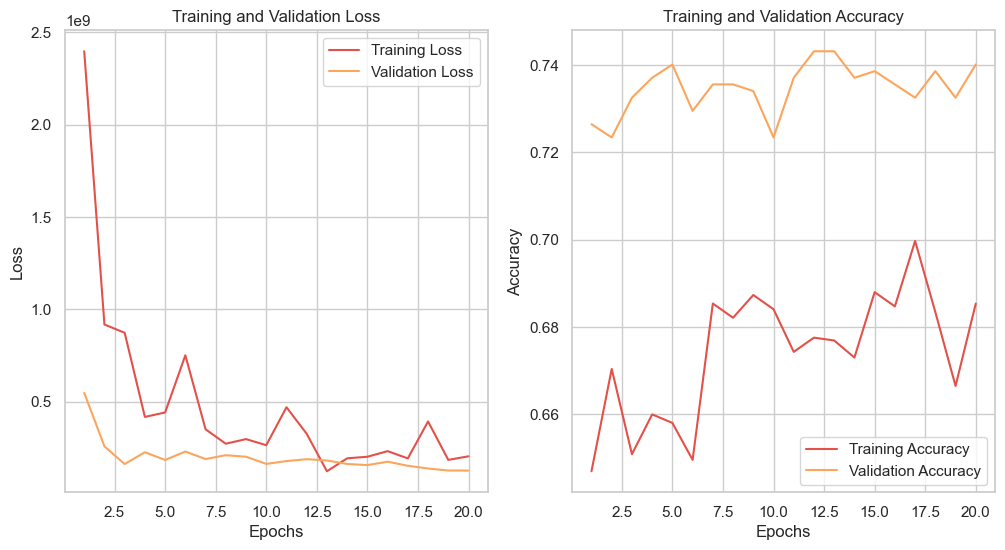

In [33]:
# Retrieve the training and validation loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a range of epochs for the x-axis
epochs = range(1, len(train_loss) + 1)

# Plot the loss and accuracy curves
plt.figure(figsize=(12, 6))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [34]:
# Define your model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
48/48 [==============================] - 1s 4ms/step - loss: 1183823360.0000 - accuracy: 0.6599 - val_loss: 292264480.0000 - val_accuracy: 0.7340
Epoch 2/20
48/48 [==============================] - 0s 2ms/step - loss: 766747264.0000 - accuracy: 0.6697 - val_loss: 268144576.0000 - val_accuracy: 0.7204
Epoch 3/20
48/48 [==============================] - 0s 2ms/step - loss: 749369600.0000 - accuracy: 0.6554 - val_loss: 264330720.0000 - val_accuracy: 0.7158
Epoch 4/20
48/48 [==============================] - 0s 2ms/step - loss: 467780128.0000 - accuracy: 0.6769 - val_loss: 201548816.0000 - val_accuracy: 0.7234
Epoch 5/20
48/48 [==============================] - 0s 2ms/step - loss: 1550064128.0000 - accuracy: 0.6853 - val_loss: 199613088.0000 - val_accuracy: 0.7340
Epoch 6/20
48/48 [==============================] - 0s 2ms/step - loss: 397798816.0000 - accuracy: 0.6938 - val_loss: 202991280.0000 - val_accuracy: 0.7295
Epoch 7/20
48/48 [==============================] - 0s 2ms/ste

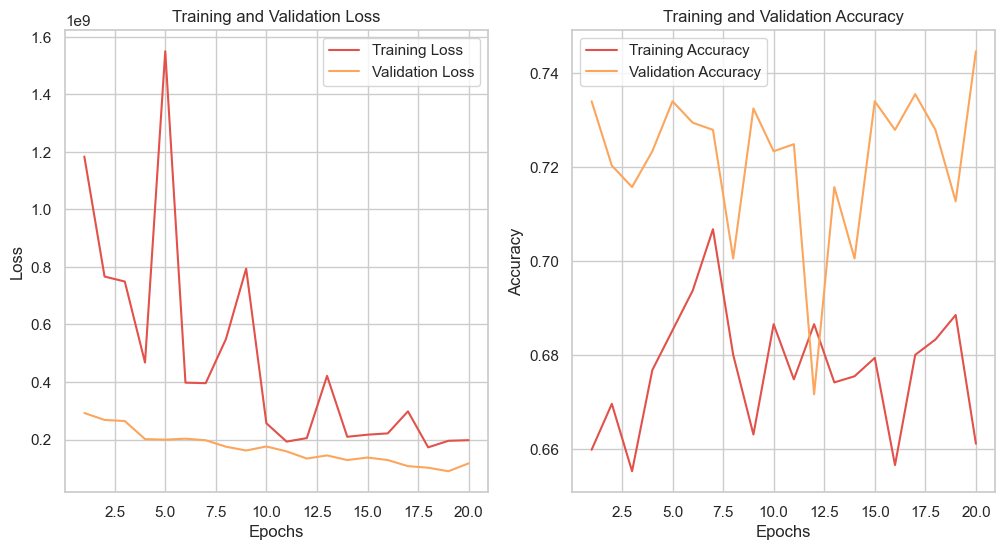

In [35]:
# Retrieve the training and validation loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a range of epochs for the x-axis
epochs = range(1, len(train_loss) + 1)

# Plot the loss and accuracy curves
plt.figure(figsize=(12, 6))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [36]:
# Define your model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
48/48 [==============================] - 1s 4ms/step - loss: 971701888.0000 - accuracy: 0.6358 - val_loss: 194829744.0000 - val_accuracy: 0.7219
Epoch 2/20
48/48 [==============================] - 0s 2ms/step - loss: 621893632.0000 - accuracy: 0.6450 - val_loss: 203985536.0000 - val_accuracy: 0.7310
Epoch 3/20
48/48 [==============================] - 0s 2ms/step - loss: 818750528.0000 - accuracy: 0.6521 - val_loss: 157180752.0000 - val_accuracy: 0.7264
Epoch 4/20
48/48 [==============================] - 0s 2ms/step - loss: 630183744.0000 - accuracy: 0.6586 - val_loss: 192290304.0000 - val_accuracy: 0.7295
Epoch 5/20
48/48 [==============================] - 0s 2ms/step - loss: 367820224.0000 - accuracy: 0.6697 - val_loss: 145446576.0000 - val_accuracy: 0.7188
Epoch 6/20
48/48 [==============================] - 0s 2ms/step - loss: 418662016.0000 - accuracy: 0.6651 - val_loss: 142474576.0000 - val_accuracy: 0.7340
Epoch 7/20
48/48 [==============================] - 0s 2ms/step 

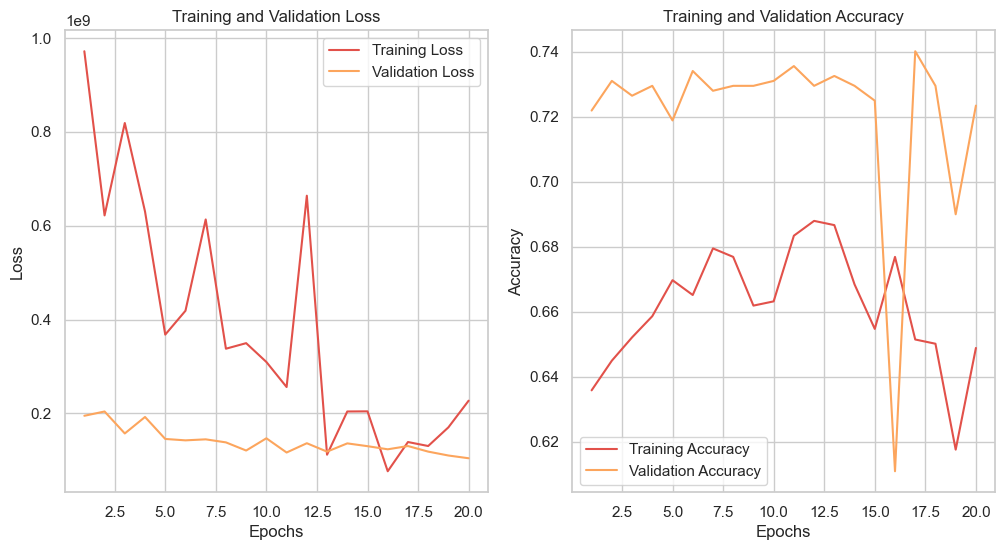

In [37]:
# Retrieve the training and validation loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a range of epochs for the x-axis
epochs = range(1, len(train_loss) + 1)

# Plot the loss and accuracy curves
plt.figure(figsize=(12, 6))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a Random Forest classifier instance
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model with the training data
random_forest.fit(X_train, y_train)

# Predict the classes for the validation data
y_pred_rf = random_forest.predict(X_val)

# Evaluate the model's performance using the validation data
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print("Random Forest accuracy: ", accuracy_rf)

Random Forest accuracy:  0.9984802431610942


In [39]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_clf.fit(X_train, y_train)

y_pred_gb = gb_clf.predict(X_val)

gb_accuracy = accuracy_score(y_val, y_pred_gb)
print("Gradient Boosting accuracy: ", gb_accuracy)

Gradient Boosting accuracy:  1.0


In [40]:
# Pisahkan dataset menjadi data pelatihan dan data pengujian
train_data = data8.sample(frac=0.8, random_state=1)
test_data = data8.drop(train_data.index)

# Tentukan variabel independen (indikator keuangan) dan variabel dependen (gain harga saham dalam persen)
X_train = train_data.drop('PRICE VAR [%]', axis=1)
y_train = train_data['PRICE VAR [%]']

# Tambahkan kolom konstan (intercept) ke variabel independen
X_train = sm.add_constant(X_train)

# Buat model regresi berganda
model = sm.OLS(y_train, X_train)

# Latih model menggunakan data pelatihan
results = model.fit()

# Cetak hasil koefisien regresi dan statistik lainnya
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          PRICE VAR [%]   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.459e+17
Date:                Sun, 19 Mar 2023   Prob (F-statistic):               0.00
Time:                        05:23:54   Log-Likelihood:                 22754.
No. Observations:                1754   AIC:                        -4.511e+04
Df Residuals:                    1554   BIC:                        -4.401e+04
Df Model:                         199                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [41]:
# Pastikan bahwa variabel dependen (2015 PRICE VAR [%]) dan variabel independen sudah dipisahkan

X = data8.drop("PRICE VAR [%]", axis=1)  # Variabel independen
y = data8["PRICE VAR [%]"]  # Variabel dependen

# Tambahkan konstanta ke variabel independen (bias)
X = sm.add_constant(X)

# Fungsi untuk backward elimination
def backward_elimination(X, y, significance_level=0.05):
    num_vars = len(X.columns)
    temp = X.copy()
    for i in range(0, num_vars):
        model = sm.OLS(y, temp).fit()
        max_p_value = max(model.pvalues)
        if max_p_value > significance_level:
            temp = temp.drop(model.pvalues.idxmax(), axis=1)
        else:
            break
    return temp

# Lakukan backward elimination
X_optimized = backward_elimination(X, y)

# Buat model OLS baru dengan variabel yang telah dioptimalkan
optimized_model = sm.OLS(y, X_optimized).fit()
print(optimized_model.summary())

                                 OLS Regression Results                                
Dep. Variable:          PRICE VAR [%]   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.068e+25
Date:                Sun, 19 Mar 2023   Prob (F-statistic):                        0.00
Time:                        05:24:06   Log-Likelihood:                          44814.
No. Observations:                2193   AIC:                                 -8.960e+04
Df Residuals:                    2179   BIC:                                 -8.952e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------

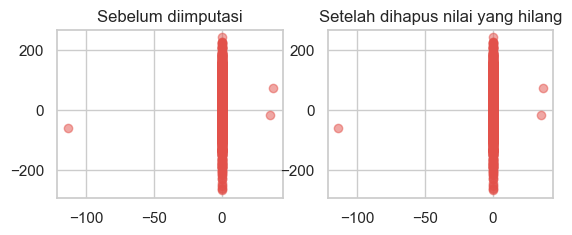

In [42]:
# Buat scatter plot variabel 'Net Income Flag' dan '2015 PRICE VAR [%]' sebelum diimputasi
plt.subplot(2, 2, 1)
plt.scatter(data8['cashConversionCycle'], data8['PRICE VAR [%]'], alpha=0.5)
plt.title('Sebelum diimputasi')



# Buat scatter plot variabel 'Net Income Flag' dan '2015 PRICE VAR [%]' setelah dihapus baris dengan nilai yang hilang
plt.subplot(2, 2, 2)
plt.scatter(data8['cashConversionCycle'], data8['PRICE VAR [%]'], alpha=0.5)
plt.title('Setelah dihapus nilai yang hilang')



plt.show()


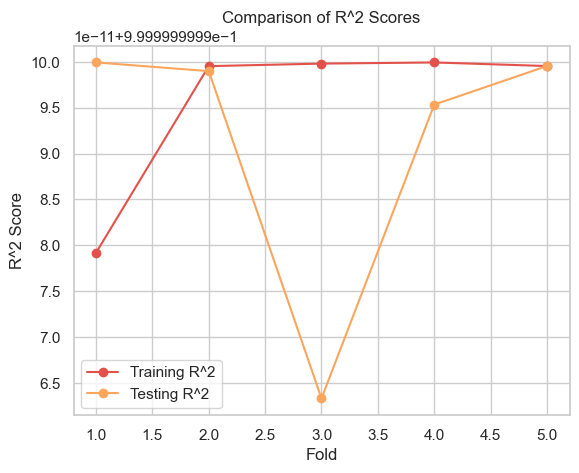

In [43]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression

# Tentukan variabel independen dan dependen untuk data pengujian
X_test = data8.drop('PRICE VAR [%]', axis=1)
y_test = data8['PRICE VAR [%]']

# Tambahkan kolom konstan (intercept) ke variabel independen untuk data pengujian
X_test = sm.add_constant(X_test)

# Membuat objek model regresi linier
lin_reg = LinearRegression()

# Menentukan jumlah fold dalam cross-validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Menghitung skor R^2 menggunakan cross-validation pada data pelatihan dan data pengujian
train_scores = cross_val_score(lin_reg, X_train, y_train, cv=kf)
test_scores = cross_val_score(lin_reg, X_test, y_test, cv=kf)

# Membuat plot perbandingan skor R^2 antara data pelatihan dan data pengujian
plt.plot(range(1, n_folds + 1), train_scores, 'o-', label='Training R^2')
plt.plot(range(1, n_folds + 1), test_scores, 'o-', label='Testing R^2')

plt.title('Comparison of R^2 Scores')
plt.xlabel('Fold')
plt.ylabel('R^2 Score')
plt.legend()
plt.grid(True)
plt.show()


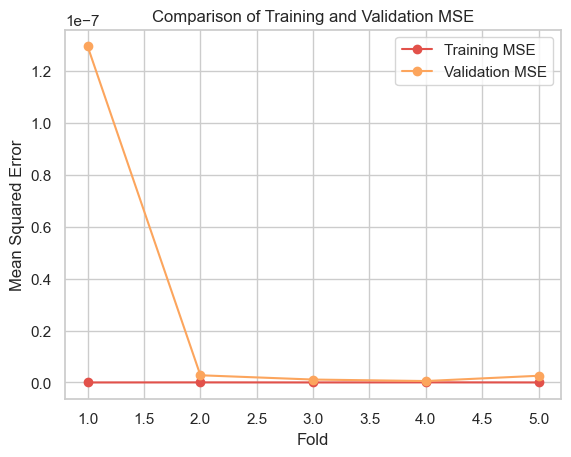

In [44]:
from sklearn.metrics import mean_squared_error

def calculate_mse(model, X, y):
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    return mse

train_errors = []
validation_errors = []

# Menentukan jumlah fold dalam cross-validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

for train_index, validation_index in kf.split(X_train):
    X_train_fold, X_validation_fold = X_train.iloc[train_index], X_train.iloc[validation_index]
    y_train_fold, y_validation_fold = y_train.iloc[train_index], y_train.iloc[validation_index]
    
    # Membuat objek model regresi linier dan melatihnya
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_fold, y_train_fold)
    
    # Menghitung train error dan validation error
    train_error = calculate_mse(lin_reg, X_train_fold, y_train_fold)
    validation_error = calculate_mse(lin_reg, X_validation_fold, y_validation_fold)
    
    train_errors.append(train_error)
    validation_errors.append(validation_error)

# Membuat plot perbandingan train error dan validation error
plt.plot(range(1, n_folds + 1), train_errors, 'o-', label='Training MSE')
plt.plot(range(1, n_folds + 1), validation_errors, 'o-', label='Validation MSE')

plt.title('Comparison of Training and Validation MSE')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()


In [45]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Tentukan variabel independen (indikator keuangan) dan variabel dependen (gain harga saham dalam persen)
X_train = train_data.drop('PRICE VAR [%]', axis=1)
y_train = train_data['PRICE VAR [%]']

# Buat model regresi linear
model = LinearRegression()

# Lakukan RFE dengan menjaga 10 fitur terbaik
rfe = RFE(model, n_features_to_select=10)
X_train_reduced = rfe.fit_transform(X_train, y_train)

# Tampilkan nama fitur yang dipilih
print(X_train.columns[rfe.support_])

Index(['Gross Margin', 'EBIT Margin', 'ebitperRevenue', 'grossProfitMargin',
       'eBITperRevenue', '2015 PRICE VAR [%]', '2016 PRICE VAR [%]',
       '2017 PRICE VAR [%]', '2018 PRICE VAR [%]', '2019 PRICE VAR [%]'],
      dtype='object')


In [46]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Memisahkan variabel independen dan dependen
X = data8.drop('2015 PRICE VAR [%]', axis=1)
y = data8['2015 PRICE VAR [%]']

# Inisialisasi model regresi linear
model = LinearRegression()

# Menentukan jumlah fold dan inisialisasi KFold
k = 5
kf = KFold(n_splits=k)

# Inisialisasi variabel untuk menampung hasil validasi
mse_train_list, mse_val_list = [], []

# Melakukan cross validation dengan k fold
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Membuat model dengan data training
    model.fit(X_train, y_train)

    # Memprediksi target pada data training dan data validasi
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Menghitung MSE pada data training dan data validasi
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_val = mean_squared_error(y_val, y_val_pred)

    # Menambahkan hasil validasi ke dalam list
    mse_train_list.append(mse_train)
    mse_val_list.append(mse_val)

# Menghitung rata-rata MSE pada data training dan data validasi
mse_train_mean = np.mean(mse_train_list)
mse_val_mean = np.mean(mse_val_list)

print(f"Mean Squared Error pada data training: {mse_train_mean:.4f}")
print(f"Mean Squared Error pada data validasi: {mse_val_mean:.4f}")

Mean Squared Error pada data training: 0.0000
Mean Squared Error pada data validasi: 0.0000


In [47]:
data7 = data8.drop(['2019 PRICE VAR [%]', '2017 PRICE VAR [%]', '2015 PRICE VAR [%]', '2018 PRICE VAR [%]', '2016 PRICE VAR [%]'], axis=1)

In [48]:
Q1 = data7["PRICE VAR [%]"].quantile(0.25)
Q3 = data7["PRICE VAR [%]"].quantile(0.75)
IQR = Q3 -Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


In [52]:
filtered_data = data7[(data7["PRICE VAR [%]"] >= lower_bound) & (data8["PRICE VAR [%]"] <= upper_bound)]

In [53]:
correlations = filtered_data.corr()["PRICE VAR [%]"].drop("PRICE VAR [%]")
correlations = correlations.sort_values(ascending=False)
print(correlations)

Class                                       0.790628
3Y Dividend per Share Growth (per Share)    0.224188
5Y Operating CF Growth (per Share)          0.205511
5Y Net Income Growth (per Share)            0.195424
10Y Net Income Growth (per Share)           0.193830
                                              ...   
Class15                                          NaN
Class16                                          NaN
Class17                                          NaN
Class18                                          NaN
Class19                                          NaN
Name: PRICE VAR [%], Length: 229, dtype: float64


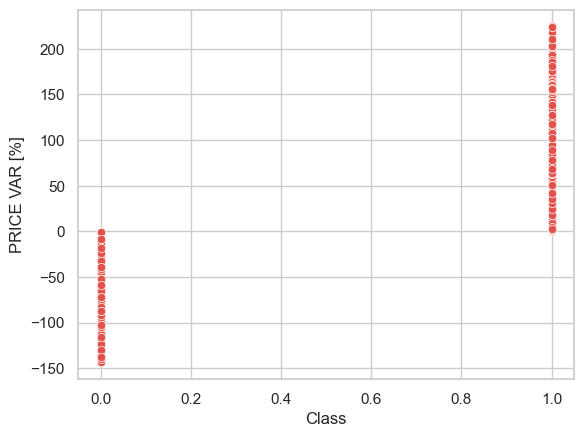

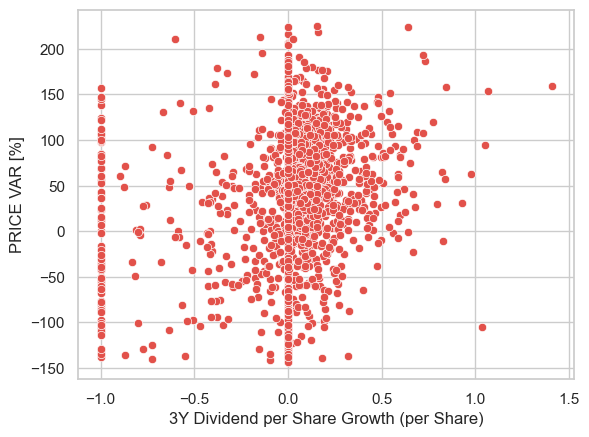

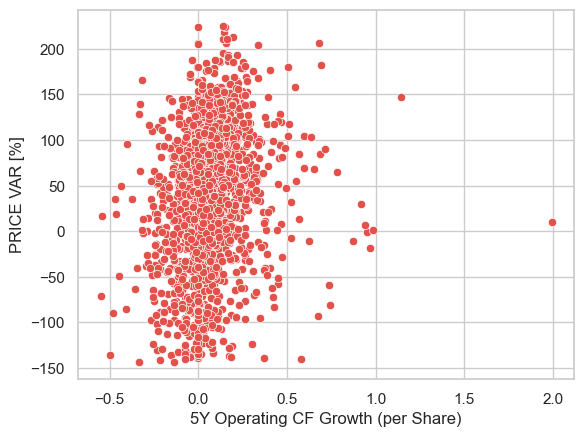

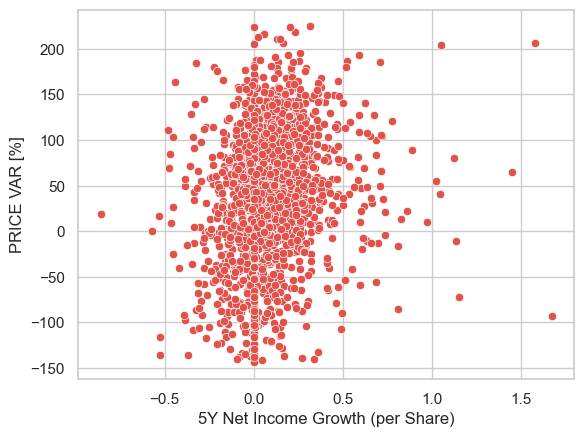

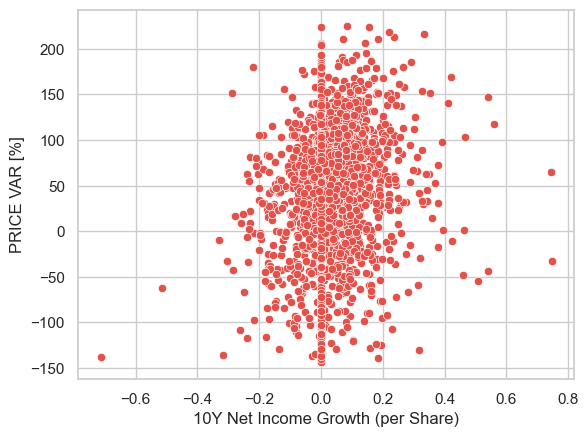

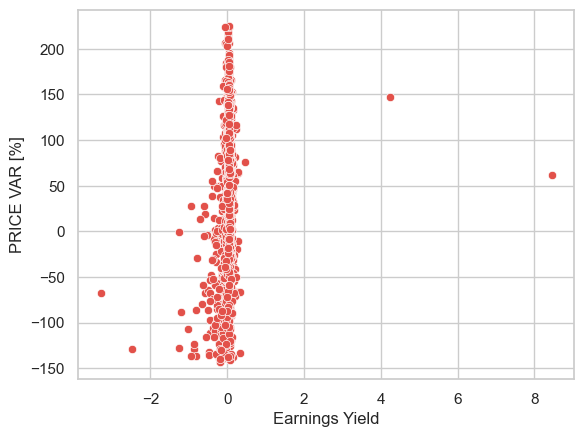

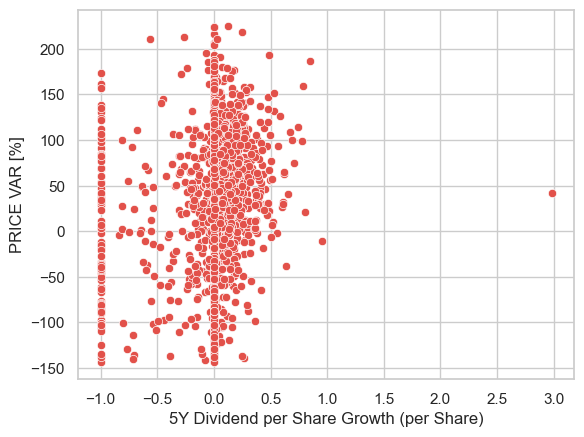

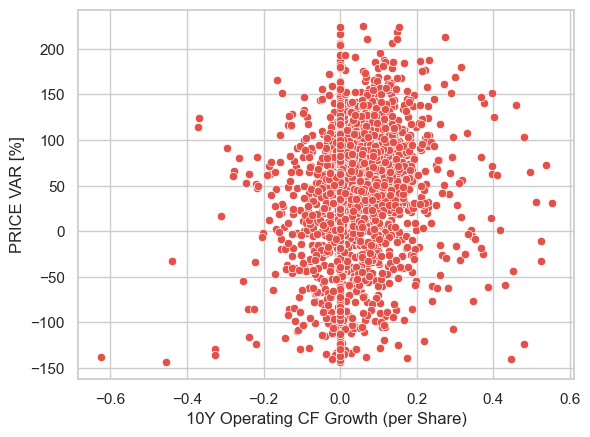

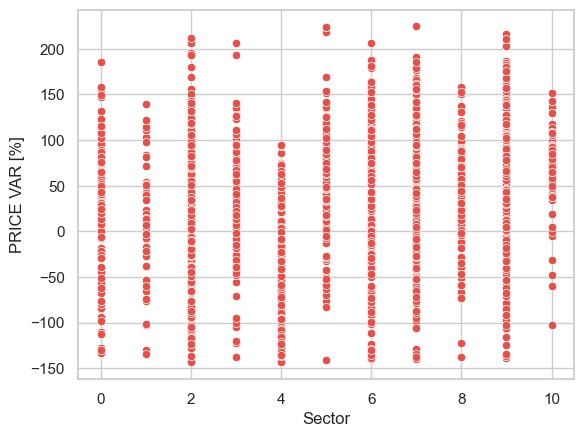

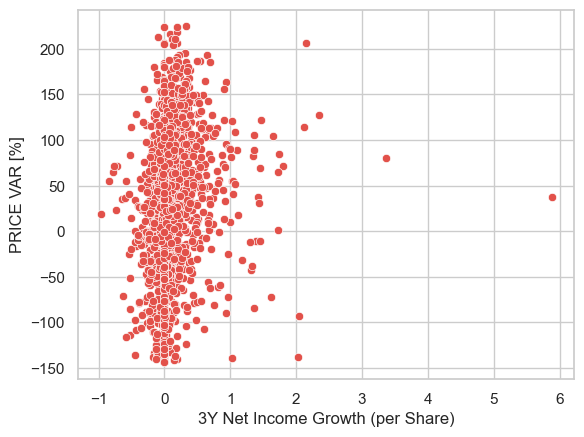

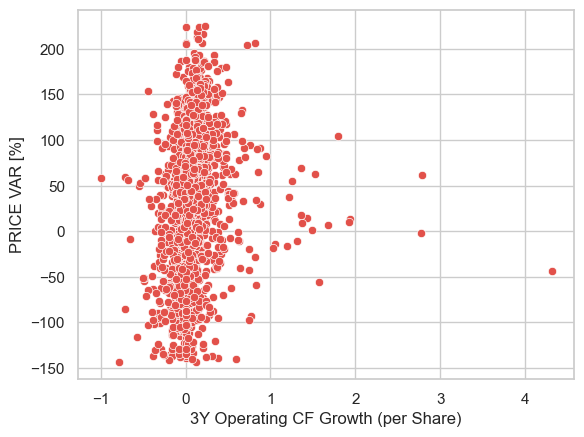

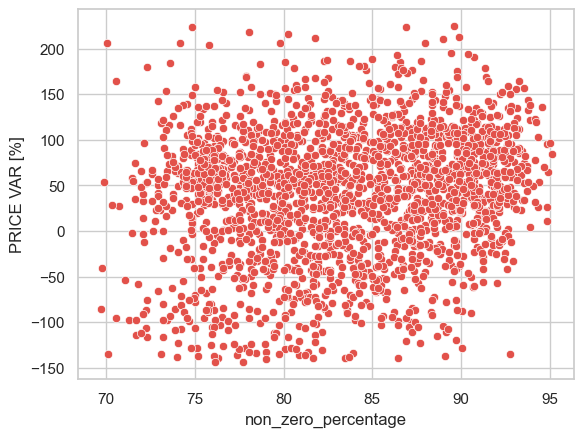

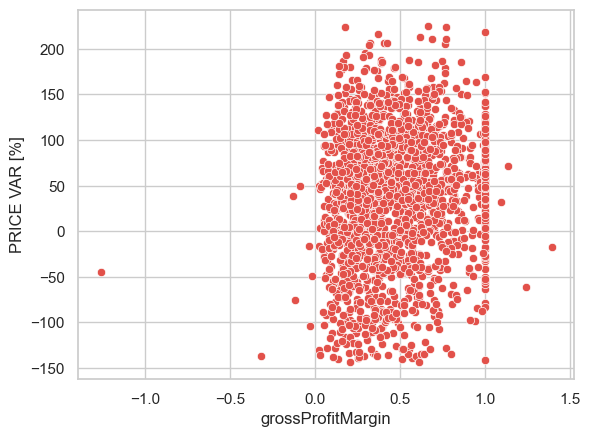

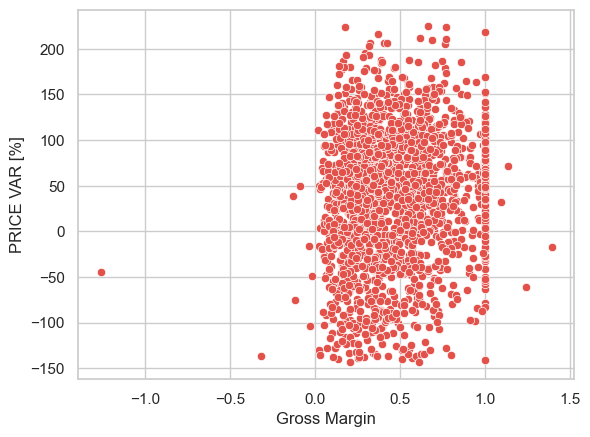

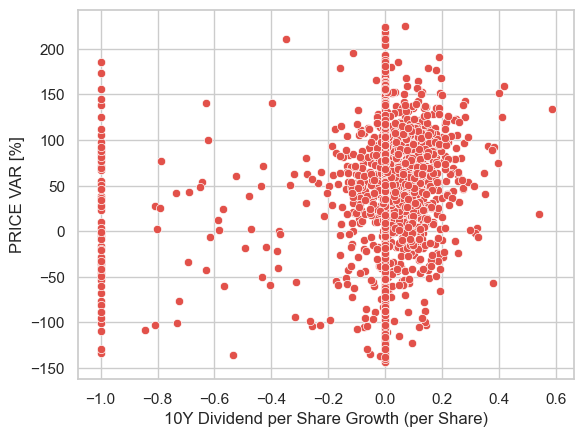

In [54]:
top_features = correlations.head(15).index

for feature in top_features:
    sns.scatterplot(x=feature, y="PRICE VAR [%]", data=filtered_data)
    plt.xlabel(feature)
    plt.ylabel("PRICE VAR [%]")
    plt.show()

In [55]:
top_features_count = 15
top_features = correlations.abs().nlargest(top_features_count).index

In [56]:
selected_data = filtered_data[top_features]
selected_data["PRICE VAR [%]"] = filtered_data["PRICE VAR [%]"]

In [57]:
correlation_matrix = selected_data.corr()

In [58]:
correlation_matrix.head()

,Class,3Y Dividend per Share Growth (per Share),5Y Operating CF Growth (per Share),5Y Net Income Growth (per Share),10Y Net Income Growth (per Share),Earnings Yield,5Y Dividend per Share Growth (per Share),10Y Operating CF Growth (per Share),Sector,3Y Net Income Growth (per Share),3Y Operating CF Growth (per Share),non_zero_percentage,grossProfitMargin,Gross Margin,10Y Dividend per Share Growth (per Share),PRICE VAR [%]
Class,1.000000,0.222284,0.148736,0.152066,0.130917,0.167945,0.195045,0.124341,0.119637,0.118478,0.101234,0.113100,0.146856,0.146513,0.140687,0.790628
3Y Dividend per Share Growth (per Share),0.222284,1.000000,0.114766,0.195517,0.097786,0.105928,0.739467,0.075915,0.030089,0.084555,0.052609,0.146303,0.100821,0.100756,0.386504,0.224188
5Y Operating CF Growth (per Share),0.148736,0.114766,1.000000,0.399105,0.326714,0.168640,0.136753,0.391471,0.037280,0.259045,0.539533,0.107650,0.029387,0.029267,0.074936,0.205511
5Y Net Income Growth (per Share),0.152066,0.195517,0.399105,1.000000,0.356607,0.096499,0.176094,0.213301,0.018364,0.506942,0.245443,0.050726,0.062846,0.062601,0.077948,0.195424
10Y Net Income Growth (per Share),0.130917,0.097786,0.326714,0.356607,1.000000,0.093143,0.108386,0.623048,-0.000773,0.140546,0.155556,0.193523,0.039904,0.039818,0.173709,0.193830


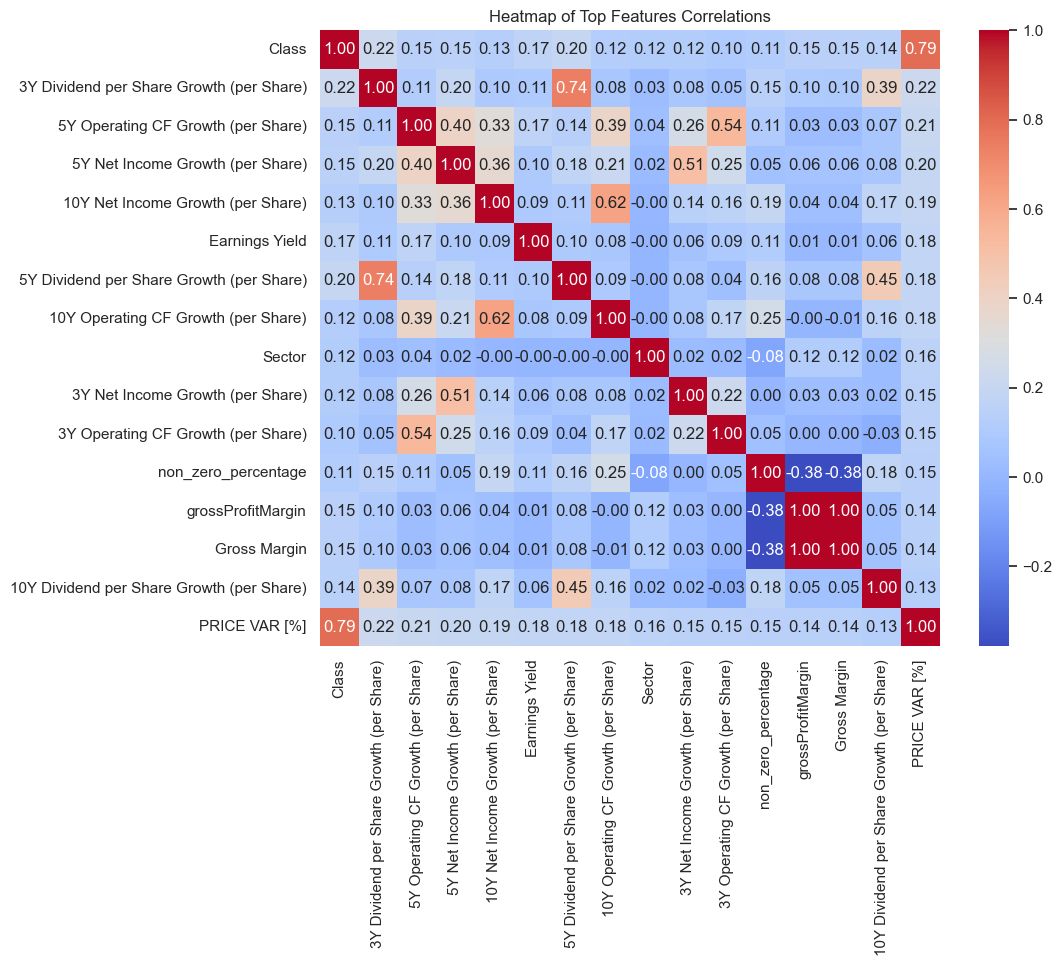

In [59]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap of Top Features Correlations")
plt.show()
